In [2]:
!pip install matplotlib

     ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.1 MB 1.3 MB/s eta 0:00:07
     ---------------------------------------- 0.0/8.1 MB 1.3 MB/s eta 0:00:07
     ---------------------------------------- 0.0/8.1 MB 245.8 kB/s eta 0:00:33
     ---------------------------------------- 0.1/8.1 MB 393.8 kB/s eta 0:00:21
     ---------------------------------------- 0.1/8.1 MB 435.7 kB/s eta 0:00:19
      --------------------------------------- 0.1/8.1 MB 423.5 kB/s eta 0:00:19
     - -------------------------------------- 0.2/8.1 MB 621.6 kB/s eta 0:00:13
     - -------------------------------------- 0.2/8.1 MB 624.4 kB/s eta 0:00:13
     - -------------------------------------- 0.2/8.1 MB 554.9 kB/s eta 0:00:15
     - -------------------------------------- 0.4/8.1 MB 813.8 kB/s eta 0:00:10
     -- ------------------------------------- 0.5/8.1 MB 907.9 kB/s eta 0:00:09
     -- ------------------------------------- 0.5/8.1


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: C:\Users\HP\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1]:
import setuptools.dist
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col, explode, desc, asc, count, avg, when, isnan, isnull
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, LongType
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'matplotlib'

In [2]:
import os
from pyspark.sql import SparkSession

# Prevent weird hostname resolution delays
os.environ["SPARK_LOCAL_HOSTNAME"] = "localhost"

spark = SparkSession.builder \
    .appName("MovieRecommendationSystem") \
    .master("local[*]") \
    .config("spark.driver.memory", "1g") \
    .config("spark.executor.memory", "1g") \
    .config("spark.driver.maxResultSize", "1g") \
    .getOrCreate()

# Silence the logs
spark.sparkContext.setLogLevel("ERROR")

print("Spark Session Created Successfully!")
print(f"Spark Version: {spark.version}")


KeyboardInterrupt: 

In [6]:
ratings_schema = StructType([
    StructField("userId", IntegerType(), True),
    StructField("movieId", IntegerType(), True),
    StructField("rating", FloatType(), True),
    StructField("timestamp", LongType(), True)
])

movies_schema = StructType([
    StructField("movieId", IntegerType(), True),
    StructField("title", StringType(), True),
    StructField("genres", StringType(), True)
])

In [7]:
# Load datasets
ratings_df = spark.read.csv("ratings.csv", header=True, schema=ratings_schema)
movies_df = spark.read.csv("movies.csv", header=True, schema=movies_schema)
tags_df = spark.read.csv("tags.csv", header=True)
links_df = spark.read.csv("links.csv", header=True)

print("Datasets loaded successfully!")
print(f"Ratings count: {ratings_df.count()}")
print(f"Movies count: {movies_df.count()}")


NameError: name 'spark' is not defined

In [ ]:
# Cell 3: Exploratory Data Analysis
print("=== RATINGS DATASET ANALYSIS ===")
ratings_df.show(5)
ratings_df.describe().show()

print("\n=== MOVIES DATASET ANALYSIS ===")
movies_df.show(5)

=== RATINGS DATASET ANALYSIS ===
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|     17|   4.0|944249077|
|     1|     25|   1.0|944250228|
|     1|     29|   2.0|943230976|
|     1|     30|   5.0|944249077|
|     1|     32|   5.0|943228858|
+------+-------+------+---------+
only showing top 5 rows

+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|           3797919|           3797918|           3797918|             3797918|
|   mean|12042.568956051986|29521.730960752706|3.5383969585441286|1.2768228648595982E9|
| stddev| 6855.375799855886|51203.281616783264|1.0593234374144431|2.5663325525844836E8|
|    min|                 1|                 1|               0.5|           825491677|
|    max|           

In [ ]:
# Check for missing values
print("\n=== MISSING VALUES CHECK ===")
print("Ratings missing values:")
ratings_df.select([count(when(col(c).isNull() | isnan(col(c)), c)).alias(c) for c in ratings_df.columns]).show()

print("Movies missing values:")
movies_df.select([count(when(col(c).isNull(), c)).alias(c) for c in movies_df.columns]).show()

# Rating distribution
print("\n=== RATING DISTRIBUTION ===")
rating_dist = ratings_df.groupBy("rating").count().orderBy("rating")
rating_dist.show()


=== MISSING VALUES CHECK ===
Ratings missing values:
+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     0|      1|     1|        1|
+------+-------+------+---------+

Movies missing values:
+-------+-----+------+
|movieId|title|genres|
+-------+-----+------+
|      0|    0|     0|
+-------+-----+------+


=== RATING DISTRIBUTION ===
+------+------+
|rating| count|
+------+------+
|  NULL|     1|
|   0.5| 63250|
|   1.0|114850|
|   1.5| 61438|
|   2.0|239110|
|   2.5|198078|
|   3.0|719102|
|   3.5|513926|
|   4.0|992780|
|   4.5|355185|
|   5.0|540199|
+------+------+



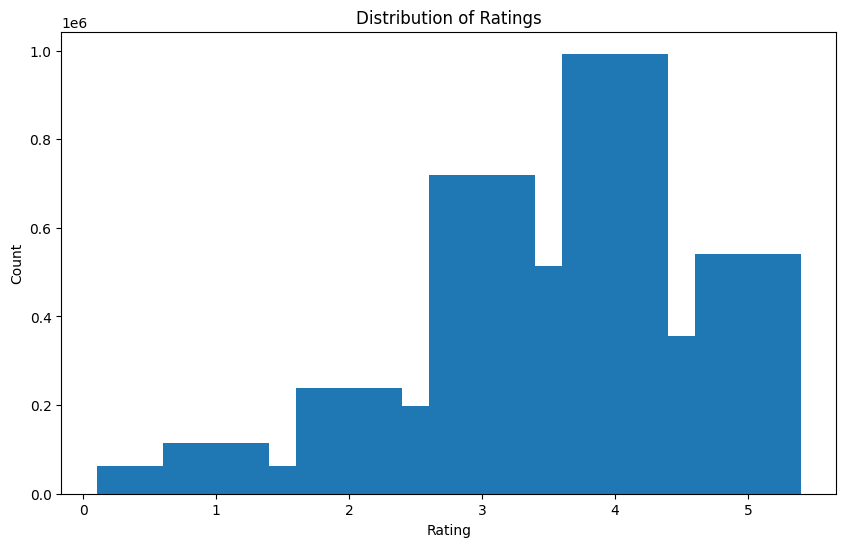

In [ ]:
# Convert to Pandas for visualization
rating_dist_pd = rating_dist.toPandas()
plt.figure(figsize=(10, 6))
plt.bar(rating_dist_pd['rating'], rating_dist_pd['count'])
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

In [ ]:
# Cell 4: Data Preprocessing and Feature Engineering
print("=== DATA PREPROCESSING ===")

# Remove rows with null values
ratings_clean = ratings_df.filter(ratings_df.rating.isNotNull() &
                                 ratings_df.userId.isNotNull() &
                                 ratings_df.movieId.isNotNull())
#Add timestamp-based features
from pyspark.sql.functions import from_unixtime, year, month, dayofweek
ratings_clean = ratings_clean.withColumn("datetime", from_unixtime(col("timestamp"))) \
                           .withColumn("year", year(from_unixtime(col("timestamp")))) \
                           .withColumn("month", month(from_unixtime(col("timestamp")))) \
                           .withColumn("dayofweek", dayofweek(from_unixtime(col("timestamp"))))

# User statistics
user_stats = ratings_clean.groupBy("userId").agg(
    count("rating").alias("num_ratings"),
    avg("rating").alias("avg_rating")
)

# Movie statistics
movie_stats = ratings_clean.groupBy("movieId").agg(
    count("rating").alias("num_ratings"),
    avg("rating").alias("avg_rating")
)

# Filter users and movies with minimum interactions (to reduce sparsity)
min_user_ratings = 20
min_movie_ratings = 20

active_users = user_stats.filter(col("num_ratings") >= min_user_ratings).select("userId")
popular_movies = movie_stats.filter(col("num_ratings") >= min_movie_ratings).select("movieId")

# Filter ratings to include only active users and popular movies
filtered_ratings = ratings_clean.join(active_users, "userId") \
                               .join(popular_movies, "movieId")

print(f"Original ratings: {ratings_clean.count()}")
print(f"Filtered ratings: {filtered_ratings.count()}")
print(f"Data reduction: {((ratings_clean.count() - filtered_ratings.count()) / ratings_clean.count()) * 100:.2f}%")


=== DATA PREPROCESSING ===
Original ratings: 3797918
Filtered ratings: 3672982
Data reduction: 3.29%


In [ ]:
# Cell 5: Train-Test Split
print("=== CREATING TRAIN-TEST SPLIT ===")

# Split data into training and testing sets
(train_data, test_data) = filtered_ratings.randomSplit([0.8, 0.2], seed=42)

print(f"Training set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")

# Cache datasets for better performance
train_data.cache()
test_data.cache()


=== CREATING TRAIN-TEST SPLIT ===
Training set size: 407237
Test set size: 101786


DataFrame[movieId: int, userId: int, rating: float, timestamp: bigint, datetime: string, year: int, month: int, dayofweek: int]

In [ ]:
# Cell 6: Build ALS Recommendation Model
print("=== BUILDING ALS MODEL ===")

# Initialize ALS model
als = ALS(maxIter=10,
          regParam=0.1,
          userCol="userId",
          itemCol="movieId",
          ratingCol="rating",
          coldStartStrategy="drop",
          nonnegative=True)

# Train the model
print("Training ALS model...")
model = als.fit(train_data)
print("Model training completed!")


=== BUILDING ALS MODEL ===
Training ALS model...
Model training completed!


In [ ]:
# Cell 7: Model Evaluation
print("=== MODEL EVALUATION ===")

# Generate predictions on test data
predictions = model.transform(test_data)
predictions.show(10)

# Evaluate the model using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
rmse = evaluator.evaluate(predictions.filter(col("prediction") != float('nan')))
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")

# Additional evaluation metrics
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")
mae = mae_evaluator.evaluate(predictions.filter(col("prediction") != float('nan')))
print(f"Mean Absolute Error (MAE): {mae:.4f}")


=== MODEL EVALUATION ===
+-------+------+------+----------+-------------------+----+-----+---------+----------+
|movieId|userId|rating| timestamp|           datetime|year|month|dayofweek|prediction|
+-------+------+------+----------+-------------------+----+-----+---------+----------+
|      4|  1645|   3.0| 831557997|1996-05-08 12:19:57|1996|    5|        4| 2.6573339|
|      6|   833|   4.5|1192195347|2007-10-12 13:22:27|2007|   10|        6| 3.8676076|
|      6|  1342|   3.0| 848521532|1996-11-20 20:25:32|1996|   11|        4| 3.7298002|
|     10|   148|   4.0|1471832439|2016-08-22 02:20:39|2016|    8|        2| 2.5230386|
|     10|  2122|   3.0| 975701035|2000-12-01 20:03:55|2000|   12|        6| 2.9602873|
|     11|  1645|   4.0| 831557508|1996-05-08 12:11:48|1996|    5|        4|  4.053817|
|     20|   833|   3.0|1155023826|2006-08-08 07:57:06|2006|    8|        3| 2.7415154|
|     21|  2122|   5.0| 975700809|2000-12-01 20:00:09|2000|   12|        6| 3.4996552|
|     25|   833|  

In [ ]:
# Cell 9: Generate Recommendations
print("=== GENERATING RECOMMENDATIONS ===")

# Generate top 10 movie recommendations for all users
user_recommendations = model.recommendForAllUsers(10)
user_recommendations.show(5, truncate=False)

# Generate top 10 user recommendations for all movies
movie_recommendations = model.recommendForAllItems(10)
movie_recommendations.show(5, truncate=False)

# Function to get recommendations for a specific user
def get_user_recommendations(user_id, num_recommendations=10):
    """Get movie recommendations for a specific user"""
    user_df = spark.createDataFrame([(user_id,)], ["userId"])
    user_recs = model.recommendForUserSubset(user_df, num_recommendations)

    # Extract movie IDs and scores
    recs_exploded = user_recs.select(
        col("userId"),
        explode(col("recommendations")).alias("recommendation")
    ).select(
        col("userId"),
        col("recommendation.movieId").alias("movieId"),
        col("recommendation.rating").alias("predicted_rating")
    )

    # Join with movie information
    recs_with_info = recs_exploded.join(movies_df, "movieId") \
                                 .select("movieId", "title", "genres", "predicted_rating") \
                                 .orderBy(desc("predicted_rating"))

    return recs_with_info

# Example: Get recommendations for user 1
sample_user_id = 1
user_recs = get_user_recommendations(sample_user_id)
print(f"\nTop 10 recommendations for User {sample_user_id}:")
user_recs.show(truncate=False)


=== GENERATING RECOMMENDATIONS ===
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|userId|recommendations                                                                                                                                                                                          |
+------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1     |[{2159, 4.547583}, {7234, 4.5122976}, {2495, 4.5036244}, {4914, 4.432571}, {2171, 4.4198804}, {7132, 4.384678}, {3093, 4.381257}, {7560, 4.3480816}, {3871, 4.3332267}, {27822, 4.3272715}]              |
|3     |[{136598, 4.3807063}, {1797, 4.365109}, {95858, 4.3083324}, {6777, 4.305509}, {4535, 4.2971783}, {3598, 4.2940993

In [ ]:
# Cell 10: Content-Based Features (Optional Enhancement)
print("=== CONTENT-BASED FEATURES ===")

from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.sql.functions import split, regexp_replace

# Process genres for content-based filtering
movies_with_genres = movies_df.withColumn("genres_clean",
                                        regexp_replace(col("genres"), "\\|", " "))

# Extract individual genres
from pyspark.sql.functions import flatten, array
genres_split = movies_with_genres.withColumn("genre_list", split(col("genres"), "\\|"))

# Get all unique genres
all_genres = genres_split.select(explode(col("genre_list")).alias("genre")).distinct()
print("Available genres:")
all_genres.show()

=== CONTENT-BASED FEATURES ===
Available genres:
+--------------------+
|               genre|
+--------------------+
|               Crime|
|             Romance|
|            Thriller|
|           Adventure|
|               Drama|
|                 War|
|         Documentary|
|             Fantasy|
|             Mystery|
|             Musical|
|           Animation|
|           Film-Noir|
| We're Comin' To ...|
|  (no genres listed)|
|                IMAX|
|              Horror|
|             Western|
|              Comedy|
|            Children|
|              Action|
+--------------------+
only showing top 20 rows



In [ ]:
# Cell 11: Model Persistence
print("=== SAVING MODEL ===")

# Save the trained model
model_path = "movie_recommendation_model"
model.write().overwrite().save(model_path)
print(f"Model saved to: {model_path}")

# Save preprocessed datasets
train_data.write.mode("overwrite").parquet("preprocessed_data/train_data")
test_data.write.mode("overwrite").parquet("preprocessed_data/test_data")
movies_df.write.mode("overwrite").parquet("preprocessed_data/movies_data")

print("Data and model saved successfully!")

=== SAVING MODEL ===
Model saved to: movie_recommendation_model
Data and model saved successfully!


In [ ]:
# Cell 12: Batch Recommendation Generation
print("=== BATCH RECOMMENDATION GENERATION ===")

def generate_batch_recommendations(output_path="user_recommendations"):
    """Generate recommendations for all users and save to disk"""

    # Generate recommendations for all users
    all_user_recs = model.recommendForAllUsers(20)

    # Explode recommendations and join with movie info
    exploded_recs = all_user_recs.select(
        col("userId"),
        explode(col("recommendations")).alias("rec")
    ).select(
        col("userId"),
        col("rec.movieId").alias("movieId"),
        col("rec.rating").alias("score")
    )

    # Join with movie information
    final_recs = exploded_recs.join(movies_df, "movieId") \
                             .select("userId", "movieId", "title", "genres", "score")

    # Save recommendations
    final_recs.write.mode("overwrite").parquet(output_path)
    print(f"Batch recommendations saved to: {output_path}")

    return final_recs

# Generate batch recommendations
batch_recs = generate_batch_recommendations()

=== BATCH RECOMMENDATION GENERATION ===
Batch recommendations saved to: user_recommendations
